In [ ]:
# !pip install  datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# !pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from datasets import load_dataset, concatenate_datasets

In [ ]:
import os
# os.environ['WANDB_DISABLED'] = 'true'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ["HF_HOME"] = "./.huggingface"
os.environ["HF_TOKEN"] = "./HF_token"

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

In [ ]:
def load_conll_data(file_path):
    """
    Load CoNLL-formatted data from a file.
    Returns a list of sentences, sentiment labels, and token-level annotations
    """
    sentences = []
    sentiments = []
    tokens_list = []
    current_sentence = []
    current_sentiment = None

    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            line = line.strip()
            if line.startswith("# sent_enum"):
                # Save the previous sentence
                if current_sentence:
                    sentences.append(" ".join(current_sentence))
                    sentiments.append(current_sentiment)
                    tokens_list.append(current_sentence)
                # Start a new sentence
                # Extract the sentiment label correctly
                parts = line.split("\t")  # Split by tab character
                if len(parts) < 2:
                    print(f"Warning: Malformed line: {line}")
                    current_sentiment = "="  # Default to "=" if parsing fails
                else:
                    current_sentiment = parts[1]  # Extract the sentiment label
                current_sentence = []
            elif line:
                # Token and label
                token, label = line.split()
                current_sentence.append(token)

    # Add the last sentence
    if current_sentence:
        sentences.append(" ".join(current_sentence))
        sentiments.append(current_sentiment)
        tokens_list.append(current_sentence)

    return sentences, sentiments, tokens_list

In [ ]:
# Load the train.conll file
train_sentences, train_sentiments, train_tokens = load_conll_data("train.conll")

# Print the first few examples
print("Sentences:", train_sentences[:2])
print("Sentiments:", train_sentiments[:2])
print("Tokens:", train_tokens[:2])

Sentences: ["After this I 'm just gonna go home drink summ hot chocolate con bolillo and sleep", 'Eating a good as posole ha']
Sentiments: ['positive', 'positive']
Tokens: [['After', 'this', 'I', "'m", 'just', 'gonna', 'go', 'home', 'drink', 'summ', 'hot', 'chocolate', 'con', 'bolillo', 'and', 'sleep'], ['Eating', 'a', 'good', 'as', 'posole', 'ha']]


In [ ]:
# Normalize quotes in the tokens
train_tokens = [[token.replace('"', "'") for token in tokens] for tokens in train_tokens]
train_sentences = [" ".join(tokens) for tokens in train_tokens]
train_sentences[:5]

["After this I 'm just gonna go home drink summ hot chocolate con bolillo and sleep",
 'Eating a good as posole ha',
 'Dale mijo , no cop no stop',
 'Damn I love listening to los cardenales de nuevo leon y el poder del norte at night',
 "I 'm pretty happy phone is finally recognizing the Spanish words I use with the swipe mode on jaja"]

In [ ]:
# Load the dev.conll file
val_sentences, val_sentiments, val_tokens = load_conll_data("dev.conll")

# Print the first few examples
print("Sentences:", val_sentences[:2])
print("Sentiments:", val_sentiments[:2])
print("Tokens:", val_tokens[:2])

Sentences: ['@brissamayen @sanluispotoyees estopp I blashhh lol jk but aww :) thanks haha ( x', "Qué mejor que pasar Valentine 's thirdwheeleando , ricura , wuu 💘"]
Sentiments: ['positive', 'positive']
Tokens: [['@brissamayen', '@sanluispotoyees', 'estopp', 'I', 'blashhh', 'lol', 'jk', 'but', 'aww', ':)', 'thanks', 'haha', '(', 'x'], ['Qué', 'mejor', 'que', 'pasar', 'Valentine', "'s", 'thirdwheeleando', ',', 'ricura', ',', 'wuu', '💘']]


In [ ]:
# Normalize quotes in the tokens
val_tokens = [[token.replace('"', "'") for token in tokens] for tokens in val_tokens]
val_sentences = [" ".join(tokens) for tokens in val_tokens]
val_sentences[:5]

['@brissamayen @sanluispotoyees estopp I blashhh lol jk but aww :) thanks haha ( x',
 "Qué mejor que pasar Valentine 's thirdwheeleando , ricura , wuu 💘",
 '#FF y de super #fashionfabolous a mi colega @beatrizmiami el duo stylist de @UnNuevoDia @Telemundo y MAS !',
 '“ @AZUCENACIERCO : Look de hoy gracias a @AngieEstilo me encanto flaca ! @UnNuevoDia @Telemundo http://t.co/UzaLFEpfQQ ” de #bcbg #summer look ☀',
 'RT @andyescalona : #brindando #celebrando #todo #compromiso #congrats #seguimosCelebrando #engagment Cc @angieestilo http://t.co/o1bvQ1KnrM']

# Fine Tuning on Spanish Dataset

In [ ]:
def load_reviews(file_path):
    df = pd.read_csv(file_path, index_col=None)
    return df

positive_df = load_reviews("Spanish/positive_dataset_es.csv")
neutral_df = load_reviews("Spanish/neutral_dataset_es.csv")
negative_df = load_reviews("Spanish/negative_dataset_es.csv")

In [ ]:
negative_df.head(5)

,text,label
0,conjunto De muy mala calidad. Parece a ropa de...,0
1,Al cabo de un mes se me ha desmontado entera. ...,0
2,No me ha encajado y me ha parecido muy endeble...,0
3,Ha llegado sin embalaje y con la pegatina del ...,0
4,"no enganchan nada, no las volvería a comprar",0


In [ ]:
# Step 1: Combine the datasets
negative_df['label'] = 0  # Negative
neutral_df['label'] = 1   # Neutral
positive_df['label'] = 2  # Positive

features = Features({
    'text': Value('string'),
    'label': ClassLabel(num_classes=3, names=['Negative', 'Neutral', 'Positive'])
})

combined_df = pd.concat([negative_df, neutral_df, positive_df], ignore_index=True)
dataset = Dataset.from_pandas(combined_df)
dataset = dataset.cast(features)

Casting the dataset:   0%|          | 0/16794 [00:00<?, ? examples/s]

In [ ]:
# 加载模型和tokenizer
model_name = "fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse"
tokenizer = AutoTokenizer.from_pretrained(model_name, src_lang="spa_Latn") # change the source language accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/16794 [00:00<?, ? examples/s]

In [ ]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']


In [ ]:
from transformers import AutoModelForSequenceClassification
from peft import get_peft_model
from peft.tuners.lora.config import LoraConfig

# Adjust LoRA settings for sentiment analysis
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=r".*llm2vec.*(self_attn\.(q|k|v|o)_proj|mlp\.(gate|up|down)_proj).*",
    bias="none",
    task_type="SEQ_CLS"
)

# Load model and apply LoRA
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,  # Sentiment analysis has three classes
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
)
model = get_peft_model(model, lora_config)
model.to(device)


config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

configuration_nllbllm2vec.py:   0%|          | 0.00/3.03k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse:
- configuration_nllbllm2vec.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_nllbllm2vec.py:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

modeling_llama_encoder.py:   0%|          | 0.00/7.44k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse:
- modeling_llama_encoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse:
- modeling_nllbllm2vec.py
- modeling_llama_encoder.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/41.2k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/998M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of NLLBLLM2VecForSequenceClassification were not initialized from the model checkpoint at fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): NLLBLLM2VecForSequenceClassification(
      (model): NLLBLLM2Vec(
        (nllb_encoder): M2M100Encoder(
          (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
          (embed_positions): M2M100SinusoidalPositionalEmbedding()
          (layers): ModuleList(
            (0-11): 12 x M2M100EncoderLayer(
              (self_attn): M2M100SdpaAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
              )
              (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              (activation_fn): ReLU()
              (fc1): Linear(in_features=1024, out_features=4096, bias=Tru

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Ensure predictions are converted from logits to class indices
    if isinstance(predictions, tuple):
        predictions = predictions[0]  # Extract logits


    predictions = predictions.argmax(axis=1)  # Get predicted class index
    labels = labels.astype(int)

    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./sentiment_model",
    num_train_epochs=1,
    # weight_decay=0.01,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    # warmup_steps=500,
    # eval_strategy="epoch",
    # save_strategy="epoch",
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=1000,  # Evaluate every 500 steps
    save_steps=1000,  # Save model every 500 steps
    learning_rate=5e-5,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    report_to='none',  # Disable logging to all integrations
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
torch.cuda.empty_cache()
trainer.train()

trainer.save_model("./es-sentiment_model")
tokenizer.save_pretrained("./es-sentiment_model")

Step,Training Loss,Validation Loss


('./es-sentiment_model/tokenizer_config.json',
 './es-sentiment_model/special_tokens_map.json',
 './es-sentiment_model/sentencepiece.bpe.model',
 './es-sentiment_model/added_tokens.json',
 './es-sentiment_model/tokenizer.json')

In [ ]:
eval_results = trainer.evaluate(test_dataset)

print(eval_results)

{'eval_loss': 0.015024612657725811, 'eval_accuracy': 0.9970229234891337, 'eval_runtime': 102.7056, 'eval_samples_per_second': 32.705, 'eval_steps_per_second': 2.045, 'epoch': 0.9991068770467401}


In [ ]:
from google.colab import files
import shutil

# Path to the model directory in Google Colab
model_dir = "./es-sentiment_model"

# Create a zip file of the model directory
shutil.make_archive("es-sentiment_model", "zip", model_dir)

'/content/es-sentiment_model.zip'

# Evaluation on Code-Switched Dataset

In [ ]:
# Tokenize the sentences
train_dataset = tokenizer(train_sentences,truncation=True, padding="max_length", max_length=128, return_tensors="pt")

val_dataset = tokenizer(val_sentences,truncation=True, padding="max_length", max_length=128, return_tensors="pt")

In [ ]:
# Map sentiment labels to integers
sentiment_mapping = {"negative": 0,  "neutral": 1, "positive": 2}
train_labels = [sentiment_mapping[sentiment] for sentiment in train_sentiments]
val_labels = [sentiment_mapping[sentiment] for sentiment in val_sentiments]

# Convert labels to a PyTorch tensor
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
print("Labels:", train_labels[:5])

Labels: tensor([2, 2, 1, 2, 2])


In [ ]:
from torch.utils.data import Dataset, DataLoader

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset
train_dataset = SentimentDataset(train_dataset, train_labels)
val_dataset = SentimentDataset(val_dataset, val_labels)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# Print the first batch
for batch in train_loader:
    print(batch["input_ids"].shape)
    print(batch["labels"])
    break

torch.Size([16, 128])
tensor([2, 2, 2, 2, 0, 2, 1, 1, 0, 0, 1, 2, 2, 2, 2, 2])


In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in val_loader:
        # Move inputs and labels to the GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Pass the inputs through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get the logits (raw model outputs)
        logits = outputs.logits

        # Convert logits to class predictions using argmax
        predictions = torch.argmax(logits, dim=1)

        # Append predictions and labels to the lists (move back to CPU if needed)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
# Compute evaluation metrics
accuracy = accuracy_score(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions, target_names=["Negative", "Neutral","Positive"])
conf_matrix = confusion_matrix(all_labels, all_predictions)


# Print the results
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix: NLLB-LLM2Vec (LINCE)")
print(conf_matrix)

Accuracy: 0.4685

Classification Report:
              precision    recall  f1-score   support

    Negative       0.28      0.77      0.41       305
     Neutral       0.29      0.11      0.16       517
    Positive       0.70      0.56      0.62      1037

    accuracy                           0.47      1859
   macro avg       0.42      0.48      0.40      1859
weighted avg       0.52      0.47      0.46      1859


Confusion Matrix: NLLB-LLM2Vec (LINCE)
[[234  38  33]
 [250  57 210]
 [356 101 580]]


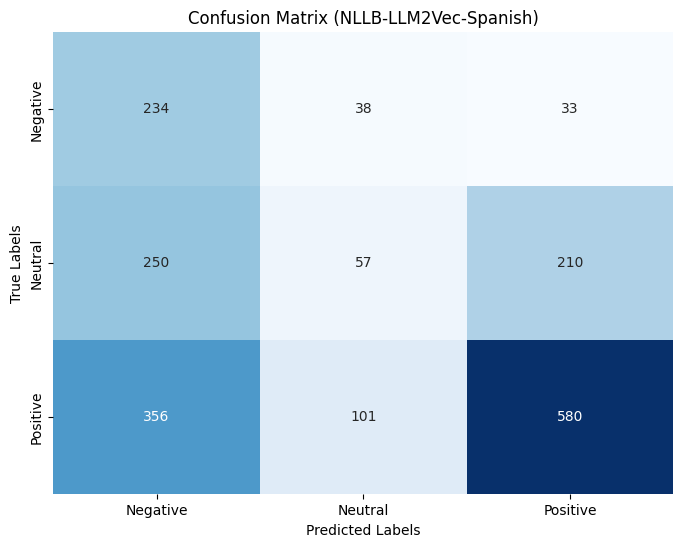

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (NLLB-LLM2Vec-Spanish)")
plt.show()

# NLLB-LLM2Vec on Dev Set (Fine-tuned on English Dataset)

In [ ]:
# Load model which was trained on English sentiments
import zipfile

# Path to the zip file
zip_file_path = "./en-NLLB-LLM2Vec.zip"

# Directory to extract the contents
extract_to = "./en-NLLB-LLM2Vec"

# Create the extraction directory if it doesn't exist
import os
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to: {extract_to}")

Files extracted to: ./en-NLLB-LLM2Vec


In [ ]:
# Load the fine-tuned model and tokenizer
model_name = "./en-NLLB-LLM2Vec"  # Path to the fine-tuned model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,  num_labels=3, `trust_remote_code=True`)

# Move the model to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

The repository for fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
The repository for fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of NLLBLLM2VecForSequenceClassification were not initialized from the model checkpoint at fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NLLBLLM2VecForSequenceClassification(
  (model): NLLBLLM2Vec(
    (nllb_encoder): M2M100Encoder(
      (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100SdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((1024,), eps=1e-05, e

In [ ]:
# Tokenize the sentences
train_dataset = tokenizer(train_sentences,truncation=True, padding="max_length", max_length=128, return_tensors="pt")

val_dataset = tokenizer(val_sentences,truncation=True, padding="max_length", max_length=128, return_tensors="pt")

In [ ]:
# Map sentiment labels to integers
sentiment_mapping = {"negative": 0,  "neutral": 1, "positive": 2}
train_labels = [sentiment_mapping[sentiment] for sentiment in train_sentiments]
val_labels = [sentiment_mapping[sentiment] for sentiment in val_sentiments]

# Convert labels to a PyTorch tensor
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
print("Labels:", train_labels[:5])

Labels: tensor([2, 2, 1, 2, 2])


In [ ]:
from torch.utils.data import Dataset, DataLoader

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset
train_dataset = SentimentDataset(train_dataset, train_labels)
val_dataset = SentimentDataset(val_dataset, val_labels)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# Print the first batch
for batch in train_loader:
    print(batch["input_ids"].shape)
    print(batch["labels"])
    break

torch.Size([16, 128])
tensor([2, 2, 2, 2, 0, 0, 2, 1, 2, 1, 2, 1, 2, 0, 0, 2])


In [ ]:
# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in val_loader:
        # Move inputs and labels to the GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Pass the inputs through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get the logits (raw model outputs)
        logits = outputs.logits

        # Convert logits to class predictions using argmax
        predictions = torch.argmax(logits, dim=1)

        # Append predictions and labels to the lists (move back to CPU if needed)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
# Compute evaluation metrics
accuracy = accuracy_score(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions, target_names=["Negative", "Neutral","Positive"])
conf_matrix = confusion_matrix(all_labels, all_predictions)


# Print the results
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix: NLLB-LLM2Vec (LINCE)")
print(conf_matrix)

Accuracy: 0.4013

Classification Report:
              precision    recall  f1-score   support

    Negative       0.40      0.67      0.50       305
     Neutral       0.32      0.66      0.43       517
    Positive       0.73      0.20      0.31      1037

    accuracy                           0.40      1859
   macro avg       0.48      0.51      0.41      1859
weighted avg       0.56      0.40      0.37      1859


Confusion Matrix: NLLB-LLM2Vec (LINCE)
[[203  86  16]
 [117 339  61]
 [186 647 204]]


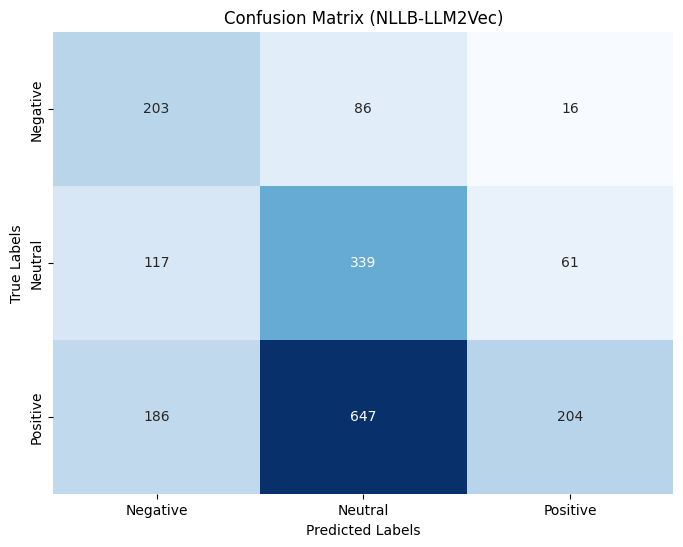

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (NLLB-LLM2Vec)")
plt.show()

In [ ]:
# Step 1: Perform prediction
prediction_output = trainer.predict(val_dataset)

# Step 2: Access predictions and true labels
preds = prediction_output.predictions
labels = prediction_output.label_ids

In [ ]:
# Step 4: Extract the correct tensor from the tuple
preds = preds[0]  # Assuming the first element contains the logits or predictions

# Step 5: Convert logits to class predictions if necessary
if len(preds.shape) == 2:  # Assuming logits are 2-dimensional
    preds = np.argmax(preds, axis=1)

# Step 6: Verify shapes
print("Labels shape:", labels.shape)
print("Predictions shape:", preds.shape)

# Step 7: Compute metrics
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    labels, preds, average='weighted'
)

# Step 8: Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Labels shape: (1859,)
Predictions shape: (1859,)
Accuracy: 0.5788058095750404
Precision: 0.5356598962060665
Recall: 0.5788058095750404
F1-score: 0.5437114200806956


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the classification report
report = classification_report(labels, preds, target_names=["Negative", "Neutral", "Positive"])

# Print the classification report
print(report)

              precision    recall  f1-score   support

    Negative       0.51      0.45      0.47       305
     Neutral       0.34      0.18      0.23       517
    Positive       0.64      0.82      0.72      1037

    accuracy                           0.58      1859
   macro avg       0.50      0.48      0.48      1859
weighted avg       0.54      0.58      0.54      1859



In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[136  58 111]
 [ 63  91 363]
 [ 69 119 849]]


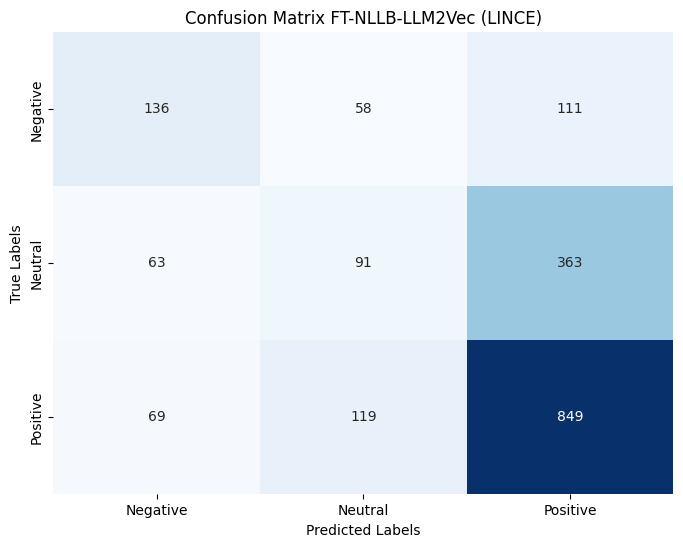

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix FT-NLLB-LLM2Vec (LINCE)")
plt.show()

# NLLB-LLM2Vec (Fine-Tuned)

In [ ]:
# Load the fine-tuned model and tokenizer
model_name = "fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse"
tokenizer = AutoTokenizer.from_pretrained(model_name, src_lang="spa_Latn")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Tokenize the sentences
train_dataset = tokenizer(train_sentences,truncation=True, padding="max_length", max_length=128, return_tensors="pt")

val_dataset = tokenizer(val_sentences,truncation=True, padding="max_length", max_length=128, return_tensors="pt")

In [ ]:
# Map sentiment labels to integers
sentiment_mapping = {"negative": 0,  "neutral": 1, "positive": 2}
train_labels = [sentiment_mapping[sentiment] for sentiment in train_sentiments]
val_labels = [sentiment_mapping[sentiment] for sentiment in val_sentiments]

# Convert labels to a PyTorch tensor
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
print("Labels:", train_labels[:5])

Labels: tensor([2, 2, 1, 2, 2])


In [ ]:
from torch.utils.data import Dataset, DataLoader

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset
train_dataset = SentimentDataset(train_dataset, train_labels)
val_dataset = SentimentDataset(val_dataset, val_labels)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

# Print the first batch
for batch in train_loader:
    print(batch["input_ids"].shape)
    print(batch["labels"])
    break

torch.Size([8, 128])
tensor([2, 2, 1, 2, 2, 2, 2, 2])


In [ ]:
from transformers import AutoModelForSequenceClassification
from peft import get_peft_model
from peft.tuners.lora.config import LoraConfig

# Adjust LoRA settings for sentiment analysis
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=r".*llm2vec.*(self_attn\.(q|k|v|o)_proj|mlp\.(gate|up|down)_proj).*",
    bias="none",
    task_type="SEQ_CLS"
)

# Load model and apply LoRA
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,  # Sentiment analysis has three classes
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
)
model = get_peft_model(model, lora_config)
model.to(device)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of NLLBLLM2VecForSequenceClassification were not initialized from the model checkpoint at fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): NLLBLLM2VecForSequenceClassification(
      (model): NLLBLLM2Vec(
        (nllb_encoder): M2M100Encoder(
          (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
          (embed_positions): M2M100SinusoidalPositionalEmbedding()
          (layers): ModuleList(
            (0-11): 12 x M2M100EncoderLayer(
              (self_attn): M2M100SdpaAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
              )
              (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              (activation_fn): ReLU()
              (fc1): Linear(in_features=1024, out_features=4096, bias=Tru

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Ensure predictions are converted from logits to class indices
    if isinstance(predictions, tuple):
        predictions = predictions[0]  # Extract logits


    predictions = predictions.argmax(axis=1)  # Get predicted class index
    labels = labels.astype(int)

    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./sentiment_model",
    num_train_epochs=3,
    # weight_decay=0.01,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    # warmup_steps=500,
    # eval_strategy="epoch",
    # save_strategy="epoch",
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=500,  # Evaluate every 500 steps
    save_steps=500,  # Save model every 500 steps
    learning_rate=5e-5,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    report_to='none',  # Disable logging to all integrations
    logging_dir="./logs",
    logging_steps=500,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
torch.cuda.empty_cache()
trainer.train()

trainer.save_model("./fine_tuned_NLLB-LLM2Vec-LINCE")

Step,Training Loss,Validation Loss,Accuracy
500,0.915000,0.867085,0.589026
1000,0.822300,0.876101,0.576654
1500,0.768700,0.847829,0.598171
2000,0.648000,0.941233,0.603012


In [ ]:
# Save the tokenizer
tokenizer.save_pretrained("./fine_tuned_NLLB-LLM2Vec-LINCE")

('./fine_tuned_NLLB-LLM2Vec-LINCE/tokenizer_config.json',
 './fine_tuned_NLLB-LLM2Vec-LINCE/special_tokens_map.json',
 './fine_tuned_NLLB-LLM2Vec-LINCE/sentencepiece.bpe.model',
 './fine_tuned_NLLB-LLM2Vec-LINCE/added_tokens.json',
 './fine_tuned_NLLB-LLM2Vec-LINCE/tokenizer.json')

In [ ]:
from google.colab import files
import shutil

# Path to the model directory in Google Colab
model_dir = "./fine_tuned_NLLB-LLM2Vec-LINCE"

# Create a zip file of the model directory
shutil.make_archive("fine_tuned_NLLB-LLM2Vec-LINCE", "zip", model_dir)

'/content/fine_tuned_NLLB-LLM2Vec-LINCE.zip'

In [ ]:
eval_results = trainer.evaluate(val_dataset)

print(eval_results)

{'eval_loss': 0.9093643426895142, 'eval_accuracy': 0.600322754168908, 'eval_runtime': 32.0506, 'eval_samples_per_second': 58.002, 'eval_steps_per_second': 3.65, 'epoch': 2.9990160708428992}


In [ ]:
# Step 1: Perform prediction
prediction_output = trainer.predict(val_dataset)

# Step 2: Access predictions and true labels
preds = prediction_output.predictions
labels = prediction_output.label_ids

In [ ]:
# Step 4: Extract the correct tensor from the tuple
preds = preds[0]  # Assuming the first element contains the logits or predictions

# Step 5: Convert logits to class predictions if necessary
if len(preds.shape) == 2:  # Assuming logits are 2-dimensional
    preds = np.argmax(preds, axis=1)

# Step 6: Verify shapes
print("Labels shape:", labels.shape)
print("Predictions shape:", preds.shape)

# Step 7: Compute metrics
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    labels, preds, average='weighted'
)

# Step 8: Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Labels shape: (1859,)
Predictions shape: (1859,)
Accuracy: 0.6030123722431415
Precision: 0.5619558758813012
Recall: 0.6030123722431415
F1-score: 0.5618762273957124


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the classification report
report = classification_report(labels, preds, target_names=["Negative", "Neutral", "Positive"])

# Print the classification report
print(report)

              precision    recall  f1-score   support

    Negative       0.58      0.47      0.52       305
     Neutral       0.39      0.17      0.24       517
    Positive       0.64      0.86      0.73      1037

    accuracy                           0.60      1859
   macro avg       0.54      0.50      0.50      1859
weighted avg       0.56      0.60      0.56      1859



In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[144  50 111]
 [ 46  90 381]
 [ 58  92 887]]


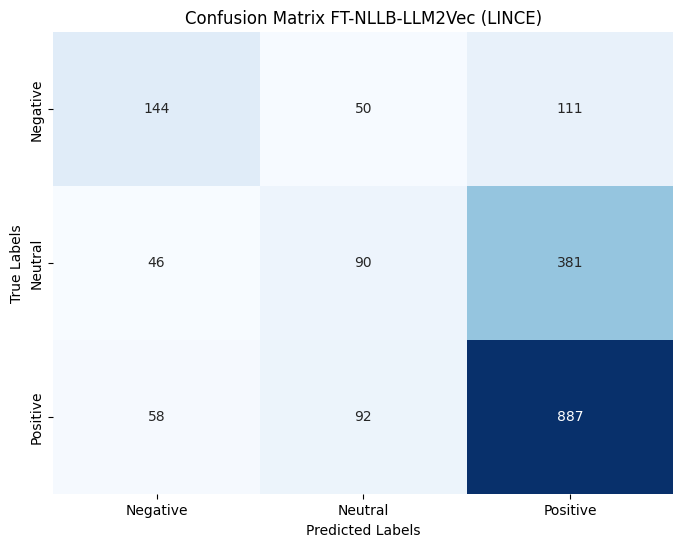

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix FT-NLLB-LLM2Vec (LINCE)")
plt.show()

# Tuning Hyperparameters (spa_Latn) Tokenizer

In [ ]:
import optuna
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and apply LoRA
model_name = "fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse"
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=r".*llm2vec.*(self_attn\.(q|k|v|o)_proj|mlp\.(gate|up|down)_proj).*",
    bias="none",
    task_type="SEQ_CLS"
)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
)
model = get_peft_model(model, lora_config)
model.to(device)

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-4, log=True)
    warmup_steps = trial.suggest_int("warmup_steps", 100, 1000)

    # Define TrainingArguments with suggested hyperparameters
    training_args = TrainingArguments(
        output_dir=f"./sentiment_model_{trial.number}",
        num_train_epochs=3,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=16,
        gradient_accumulation_steps=4,
        warmup_steps=warmup_steps,
        eval_strategy="steps",
        save_strategy="steps",
        eval_steps=500,
        save_steps=500,
        learning_rate=learning_rate,
        fp16=True,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
        greater_is_better=True,
        report_to='none',
        logging_dir="./logs",
        logging_steps=500,
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()

    # Return the metric to optimize (e.g., validation accuracy)
    return eval_results["eval_accuracy"]

# Create an Optuna study
study = optuna.create_study(direction="maximize")  # Maximize accuracy

# Run the study
study.optimize(objective, n_trials=1)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of NLLBLLM2VecForSequenceClassification were not initialized from the model checkpoint at fdschmidt93/NLLB-LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-12-15 06:00:08,317] A new study created in memory with name: no-name-589867f5-c26e-40fa-b465-221b6d637ea8


Step,Training Loss,Validation Loss,Accuracy
500,0.973900,0.887708,0.571275
1000,0.838500,0.869223,0.584723
1500,0.803400,0.851418,0.607854
2000,0.760800,0.883090,0.603012


[I 2024-12-15 06:46:29,618] Trial 0 finished with value: 0.6078536847767617 and parameters: {'learning_rate': 1.3951650108905263e-05, 'warmup_steps': 293}. Best is trial 0 with value: 0.6078536847767617.


Best hyperparameters: {'learning_rate': 1.3951650108905263e-05, 'warmup_steps': 293}
Best accuracy: 0.6078536847767617


In [ ]:
training_args = TrainingArguments(
    output_dir="./sentiment_model",
    num_train_epochs=3,
    # weight_decay=0.01,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    warmup_steps=293,
    # eval_strategy="epoch",
    # save_strategy="epoch",
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=500,  # Evaluate every 500 steps
    save_steps=500,  # Save model every 500 steps
    learning_rate=1.395165e-5,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    report_to='none',  # Disable logging to all integrations
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
torch.cuda.empty_cache()
trainer.train()

trainer.save_model("./fine_tuned_NLLB-LLM2Vec-LINCE-v2")
tokenizer.save_pretrained("./fine_tuned_NLLB-LLM2Vec-LINCE-v2")

Step,Training Loss,Validation Loss,Accuracy
500,0.762800,0.889621,0.569123
1000,0.693100,0.942993,0.570737
1500,0.656300,0.924732,0.567509
2000,0.575500,1.034747,0.578806


('./fine_tuned_NLLB-LLM2Vec-LINCE-v2/tokenizer_config.json',
 './fine_tuned_NLLB-LLM2Vec-LINCE-v2/special_tokens_map.json',
 './fine_tuned_NLLB-LLM2Vec-LINCE-v2/sentencepiece.bpe.model',
 './fine_tuned_NLLB-LLM2Vec-LINCE-v2/added_tokens.json',
 './fine_tuned_NLLB-LLM2Vec-LINCE-v2/tokenizer.json')

# XLMR-SM (Pre-trained)

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
# Tokenize the sentences
train_dataset = tokenizer(train_sentences,truncation=True, padding="max_length", max_length=512, return_tensors="pt")

val_dataset = tokenizer(val_sentences,truncation=True, padding="max_length", max_length=512, return_tensors="pt")

In [ ]:
# Map sentiment labels to integers
sentiment_mapping = {"negative": 0,  "neutral": 1, "positive": 2}
train_labels = [sentiment_mapping[sentiment] for sentiment in train_sentiments]
val_labels = [sentiment_mapping[sentiment] for sentiment in val_sentiments]

In [ ]:
# Convert labels to a PyTorch tensor
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
print("Labels:", train_labels[:5])

Labels: tensor([2, 2, 1, 2, 2])


In [ ]:
from torch.utils.data import Dataset, DataLoader

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset
train_dataset = SentimentDataset(train_dataset, train_labels)
val_dataset = SentimentDataset(val_dataset, val_labels)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# Print the first batch
for batch in train_loader:
    print(batch["input_ids"].shape)
    print(batch["labels"])
    break

torch.Size([32, 512])
tensor([2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 0,
        1, 2, 1, 2, 2, 0, 2, 1])


In [ ]:
# Move the model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Iterate over the validation dataset
for batch in val_loader:
    # Move batch to the device
    inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
    labels = batch["labels"].to(device)

    # Generate predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Convert logits to class predictions
    preds = np.argmax(logits.cpu().numpy(), axis=1)

    # Store predictions and labels
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

# Verify shapes
print("Labels shape:", np.array(all_labels).shape)
print("Predictions shape:", np.array(all_preds).shape)

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='macro'
)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Labels shape: (1859,)
Predictions shape: (1859,)
Accuracy: 0.50080688542227
Precision: 0.5211651103975047
Recall: 0.5563694558585713
F1-score: 0.5084957077249164


In [ ]:
classification_rep = classification_report(all_labels, all_preds, target_names=["Negative", "Neutral","Positive"])
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.5008

Classification Report:
              precision    recall  f1-score   support

    Negative       0.48      0.70      0.57       305
     Neutral       0.35      0.56      0.43       517
    Positive       0.74      0.42      0.53      1037

    accuracy                           0.50      1859
   macro avg       0.52      0.56      0.51      1859
weighted avg       0.59      0.50      0.51      1859


Confusion Matrix:
[[213  67  25]
 [104 287 126]
 [129 477 431]]


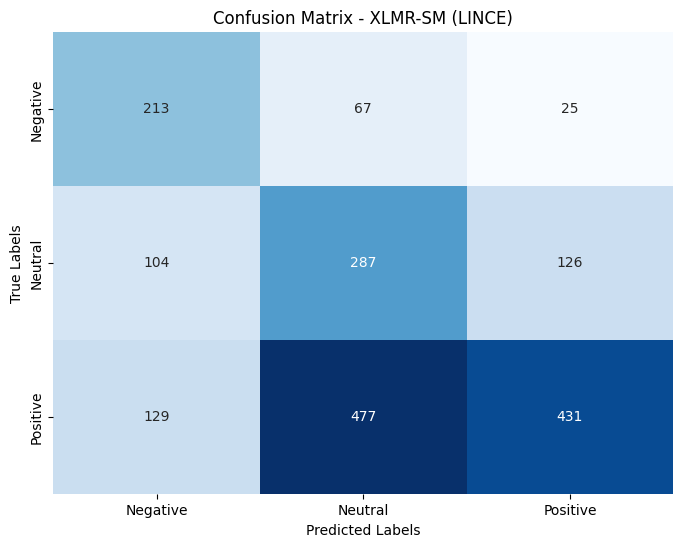

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - XLMR-SM (LINCE)")
plt.show()

# XLMR-SM (Fine-Tuned on Spanish)

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [ ]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 16794
})

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/16794 [00:00<?, ? examples/s]

In [ ]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Ensure predictions are converted from logits to class indices
    if isinstance(predictions, tuple):
        predictions = predictions[0]  # Extract logits


    predictions = predictions.argmax(axis=1)  # Get predicted class index
    labels = labels.astype(int)

    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [ ]:
# TRAINING MODEL WITH BEST HYPERPARAMETERS

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1.12e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    report_to='none',
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_XLMR-LINCE-Spanish")
tokenizer.save_pretrained("./fine_tuned_XLMR-LINCE-Spanish")

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.022467,0.995237
2,0.005600,0.018636,0.996130


('./fine_tuned_XLMR-LINCE-Spanish/tokenizer_config.json',
 './fine_tuned_XLMR-LINCE-Spanish/special_tokens_map.json',
 './fine_tuned_XLMR-LINCE-Spanish/sentencepiece.bpe.model',
 './fine_tuned_XLMR-LINCE-Spanish/added_tokens.json',
 './fine_tuned_XLMR-LINCE-Spanish/tokenizer.json')

In [ ]:
from google.colab import files
import shutil

# Path to the model directory in Google Colab
model_dir = "./fine_tuned_XLMR-LINCE-Spanish"

# Create a zip file of the model directory
shutil.make_archive("fine_tuned_XLMR-LINCE-Spanish", "zip", model_dir)

'/content/fine_tuned_XLMR-LINCE-Spanish.zip'

### Evaluating on Code-Switched Data

In [ ]:
# Tokenize the sentences
train_dataset = tokenizer(train_sentences,truncation=True, padding="max_length", max_length=512, return_tensors="pt")

val_dataset = tokenizer(val_sentences,truncation=True, padding="max_length", max_length=512, return_tensors="pt")

In [ ]:
# Map sentiment labels to integers
sentiment_mapping = {"negative": 0,  "neutral": 1, "positive": 2}
train_labels = [sentiment_mapping[sentiment] for sentiment in train_sentiments]
val_labels = [sentiment_mapping[sentiment] for sentiment in val_sentiments]

In [ ]:
# Convert labels to a PyTorch tensor
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
print("Labels:", train_labels[:5])

Labels: tensor([2, 2, 1, 2, 2])


In [ ]:
from torch.utils.data import Dataset, DataLoader

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset
train_dataset = SentimentDataset(train_dataset, train_labels)
val_dataset = SentimentDataset(val_dataset, val_labels)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# Print the first batch
for batch in train_loader:
    print(batch["input_ids"].shape)
    print(batch["labels"])
    break

torch.Size([16, 512])
tensor([2, 2, 2, 2, 1, 1, 0, 2, 2, 0, 0, 2, 1, 2, 2, 2])


In [ ]:
# Move the model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Iterate over the validation dataset
for batch in val_loader:
    # Move batch to the device
    inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
    labels = batch["labels"].to(device)

    # Generate predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Convert logits to class predictions
    preds = np.argmax(logits.cpu().numpy(), axis=1)

    # Store predictions and labels
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

# Verify shapes
print("Labels shape:", np.array(all_labels).shape)
print("Predictions shape:", np.array(all_preds).shape)

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='macro'
)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Labels shape: (1859,)
Predictions shape: (1859,)
Accuracy: 0.5443786982248521
Precision: 0.49907072160485066
Recall: 0.5440063865226465
F1-score: 0.509669768117663


In [ ]:
classification_rep = classification_report(all_labels, all_preds, target_names=["Negative", "Neutral","Positive"])
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.5444

Classification Report:
              precision    recall  f1-score   support

    Negative       0.43      0.69      0.53       305
     Neutral       0.36      0.33      0.35       517
    Positive       0.71      0.61      0.65      1037

    accuracy                           0.54      1859
   macro avg       0.50      0.54      0.51      1859
weighted avg       0.57      0.54      0.55      1859


Confusion Matrix:
[[211  58  36]
 [122 173 222]
 [160 249 628]]


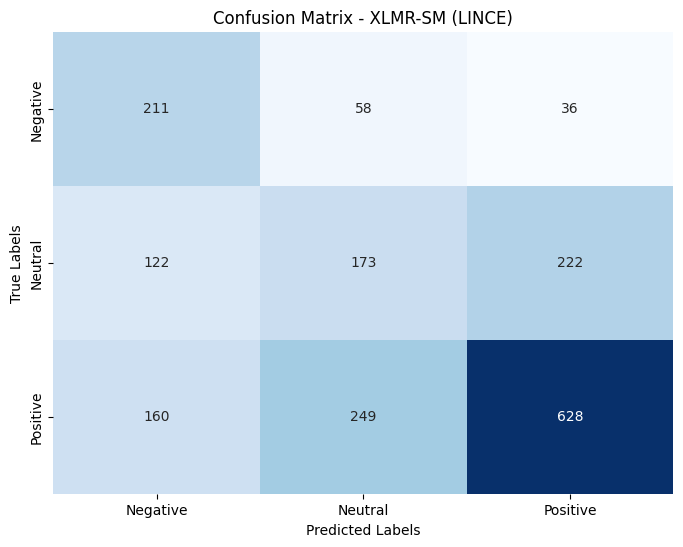

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - XLMR-SM (LINCE)")
plt.show()

# XLMR-SM (Fine-Tuned on Code-Switched)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Ensure predictions are converted from logits to class indices
    if isinstance(predictions, tuple):
        predictions = predictions[0]  # Extract logits


    predictions = predictions.argmax(axis=1)  # Get predicted class index
    labels = labels.astype(int)

    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

## Tuning hyperparams

In [ ]:
import optuna

# Define the objective function for Optuna
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    num_epochs = trial.suggest_int("num_epochs", 2, 5)

    # Define training arguments with suggested hyperparameters
    training_args = TrainingArguments(
        output_dir=f"./results_{trial.number}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        fp16=True,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        report_to='none',
    )

    trainer = Trainer(
        model=AutoModelForSequenceClassification.from_pretrained(model_name),
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()
    return eval_results["eval_accuracy"]  # Return the metric to optimize

# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Run the study
study.optimize(objective, n_trials=3)  # Run 3 trials

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

In [ ]:
# TRAINING MODEL WITH BEST HYPERPARAMETERS

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1.12e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    report_to='none',
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_XLMR-LINCE")
tokenizer.save_pretrained("./fine_tuned_XLMR-LINCE")

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.848817,0.618612
2,0.816500,0.837103,0.614309
3,0.745200,0.879088,0.602474
4,0.691900,0.916092,0.605702


('./fine_tuned_XLMR-LINCE/tokenizer_config.json',
 './fine_tuned_XLMR-LINCE/special_tokens_map.json',
 './fine_tuned_XLMR-LINCE/sentencepiece.bpe.model',
 './fine_tuned_XLMR-LINCE/added_tokens.json',
 './fine_tuned_XLMR-LINCE/tokenizer.json')

In [ ]:
# Step 1: Perform prediction
prediction_output = trainer.predict(val_dataset)

# Step 2: Access predictions and true labels
preds = prediction_output.predictions
labels = prediction_output.label_ids

In [ ]:
labels.shape

(1859,)

In [ ]:
preds.shape

(1859, 3)

In [ ]:
# Step 3: Convert logits to class predictions if necessary
if len(preds.shape) == 2:  # Assuming logits are 2-dimensional
    preds = np.argmax(preds, axis=1)  # Convert logits to class predictions
else:
    raise ValueError("Logits should be 2-dimensional (batch_size, num_classes).")

# Step 4: Verify shapes
print("Labels shape:", labels.shape)  # Should be (batch_size,)
print("Predictions shape:", preds.shape)  # Should be (batch_size,)

# Step 5: Compute metrics
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    labels, preds, average='weighted'
)

# Step 6: Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Labels shape: (1859,)
Predictions shape: (1859,)
Accuracy: 0.6186121570736955
Precision: 0.5697318677934075
Recall: 0.6186121570736955
F1-score: 0.5498412303251029


[[192  18  95]
 [ 84  39 394]
 [ 83  35 919]]


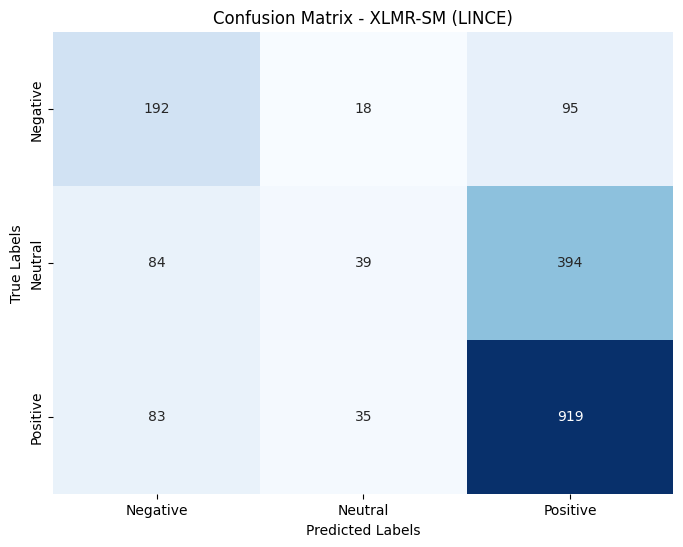

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, preds)
print(conf_matrix)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - XLMR-SM (LINCE)")
plt.show()

In [ ]:
from google.colab import files
import shutil

# Path to the model directory in Google Colab
model_dir = "./fine_tuned_XLMR-LINCE"

# Create a zip file of the model directory
shutil.make_archive("fine_tuned_XLMR-LINCE", "zip", model_dir)

'/content/fine_tuned_XLMR-LINCE.zip'

# ROBERTA-spanish-sentiment-analysis

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "UMUTeam/roberta-spanish-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
# Tokenize the sentences
train_dataset = tokenizer(train_sentences,truncation=True, padding="max_length", max_length=512, return_tensors="pt")

val_dataset = tokenizer(val_sentences,truncation=True, padding="max_length", max_length=512, return_tensors="pt")

In [ ]:
from torch.utils.data import Dataset, DataLoader

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset
train_dataset = SentimentDataset(train_dataset, train_labels)
val_dataset = SentimentDataset(val_dataset, val_labels)

In [ ]:
# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# Print the first batch
for batch in train_loader:
    print(batch["input_ids"].shape)
    print(batch["labels"])
    break

torch.Size([16, 512])
tensor([2, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 1, 2, 0, 2])


In [ ]:
# Move the model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Iterate over the validation dataset
for batch in val_loader:
    # Move batch to the device
    inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
    labels = batch["labels"].to(device)

    # Generate predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Convert logits to class predictions
    preds = np.argmax(logits.cpu().numpy(), axis=1)

    # Store predictions and labels
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

# Verify shapes
print("Labels shape:", np.array(all_labels).shape)
print("Predictions shape:", np.array(all_preds).shape)


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='macro'
)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.4443249058633674
Precision: 0.4868558862382621
Recall: 0.47403243124944433
F1-score: 0.4411130870049847


[[132 150  23]
 [ 69 330 118]
 [111 562 364]]


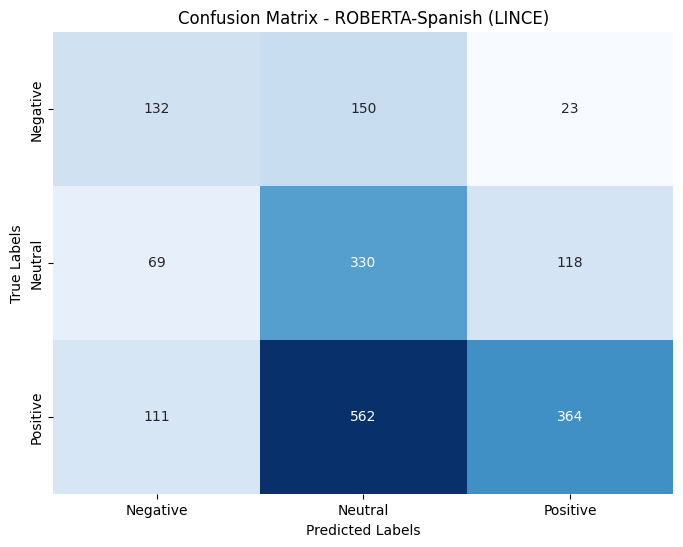

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(conf_matrix)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - ROBERTA-Spanish (LINCE)")
plt.show()

# ROBERTA-Spanish (Fine Tuned on Spanish)

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "UMUTeam/roberta-spanish-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/16794 [00:00<?, ? examples/s]

In [ ]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Ensure predictions are converted from logits to class indices
    if isinstance(predictions, tuple):
        predictions = predictions[0]  # Extract logits


    predictions = predictions.argmax(axis=1)  # Get predicted class index
    labels = labels.astype(int)

    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [ ]:
# TRAINING MODEL WITH BEST HYPERPARAMETERS

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    report_to='none',
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_ROBERTA-LINCE-Spanish")
tokenizer.save_pretrained("./fine_tuned_ROBERTA-LINCE-Spanish")

Epoch,Training Loss,Validation Loss,Accuracy
1,0.075200,0.021870,0.994046
2,0.008900,0.014629,0.997023
3,0.000300,0.014015,0.997023


('./fine_tuned_ROBERTA-LINCE-Spanish/tokenizer_config.json',
 './fine_tuned_ROBERTA-LINCE-Spanish/special_tokens_map.json',
 './fine_tuned_ROBERTA-LINCE-Spanish/vocab.json',
 './fine_tuned_ROBERTA-LINCE-Spanish/merges.txt',
 './fine_tuned_ROBERTA-LINCE-Spanish/added_tokens.json',
 './fine_tuned_ROBERTA-LINCE-Spanish/tokenizer.json')

In [ ]:
from google.colab import files
import shutil

# Path to the model directory in Google Colab
model_dir = "./fine_tuned_ROBERTA-LINCE-Spanish"

# Create a zip file of the model directory
shutil.make_archive("fine_tuned_ROBERTA-LINCE-Spanish", "zip", model_dir)

'/content/fine_tuned_ROBERTA-LINCE-Spanish.zip'

## Evaluating on Code-Switched Data

In [ ]:
# Tokenize the sentences
train_dataset = tokenizer(train_sentences,truncation=True, padding="max_length", max_length=512, return_tensors="pt")

val_dataset = tokenizer(val_sentences,truncation=True, padding="max_length", max_length=512, return_tensors="pt")

In [ ]:
# Map sentiment labels to integers
sentiment_mapping = {"negative": 0,  "neutral": 1, "positive": 2}
train_labels = [sentiment_mapping[sentiment] for sentiment in train_sentiments]
val_labels = [sentiment_mapping[sentiment] for sentiment in val_sentiments]

In [ ]:
# Convert labels to a PyTorch tensor
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
print("Labels:", train_labels[:5])

Labels: tensor([2, 2, 1, 2, 2])


In [ ]:
from torch.utils.data import Dataset, DataLoader

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset
train_dataset = SentimentDataset(train_dataset, train_labels)
val_dataset = SentimentDataset(val_dataset, val_labels)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# Print the first batch
for batch in train_loader:
    print(batch["input_ids"].shape)
    print(batch["labels"])
    break

torch.Size([16, 512])
tensor([2, 0, 1, 0, 2, 0, 0, 1, 2, 1, 2, 0, 2, 2, 0, 0])


In [ ]:
# Move the model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Iterate over the validation dataset
for batch in val_loader:
    # Move batch to the device
    inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
    labels = batch["labels"].to(device)

    # Generate predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Convert logits to class predictions
    preds = np.argmax(logits.cpu().numpy(), axis=1)

    # Store predictions and labels
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

# Verify shapes
print("Labels shape:", np.array(all_labels).shape)
print("Predictions shape:", np.array(all_preds).shape)

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='macro'
)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Labels shape: (1859,)
Predictions shape: (1859,)
Accuracy: 0.5142549757934374
Precision: 0.4471294908075325
Recall: 0.48717379585883247
F1-score: 0.4477618141251563


In [ ]:
classification_rep = classification_report(all_labels, all_preds, target_names=["Negative", "Neutral","Positive"])
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.5143

Classification Report:
              precision    recall  f1-score   support

    Negative       0.34      0.62      0.44       305
     Neutral       0.33      0.20      0.25       517
    Positive       0.67      0.64      0.65      1037

    accuracy                           0.51      1859
   macro avg       0.45      0.49      0.45      1859
weighted avg       0.52      0.51      0.51      1859


Confusion Matrix:
[[190  53  62]
 [149 103 265]
 [219 155 663]]


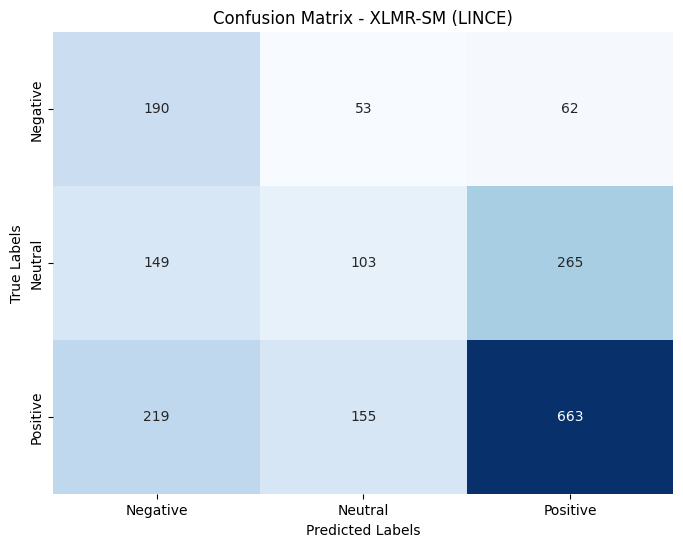

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - XLMR-SM (LINCE)")
plt.show()

# ROBERTA-Spanish (Fine Tuned on Code-Switched)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Ensure predictions are converted from logits to class indices
    if isinstance(predictions, tuple):
        predictions = predictions[0]  # Extract logits


    predictions = predictions.argmax(axis=1)  # Get predicted class index
    labels = labels.astype(int)

    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [ ]:
# TRAINING MODEL WITH BEST HYPERPARAMETERS

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    report_to='none',
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_ROBERTA-LINCE")
tokenizer.save_pretrained("./fine_tuned_ROBERTA-LINCE")

Epoch,Training Loss,Validation Loss,Accuracy
1,0.916600,0.852484,0.603012
2,0.672700,0.915410,0.582033
3,0.374500,1.233330,0.566434


Epoch,Training Loss,Validation Loss,Accuracy
1,0.916600,0.852484,0.603012
2,0.672700,0.915410,0.582033
3,0.374500,1.233330,0.566434


('./fine_tuned_ROBERTA-LINCE/tokenizer_config.json',
 './fine_tuned_ROBERTA-LINCE/special_tokens_map.json',
 './fine_tuned_ROBERTA-LINCE/vocab.json',
 './fine_tuned_ROBERTA-LINCE/merges.txt',
 './fine_tuned_ROBERTA-LINCE/added_tokens.json',
 './fine_tuned_ROBERTA-LINCE/tokenizer.json')

In [ ]:
# Step 1: Perform prediction
prediction_output = trainer.predict(val_dataset)

# Step 2: Access predictions and true labels
preds = prediction_output.predictions
labels = prediction_output.label_ids

In [ ]:
# Step 3: Convert logits to class predictions if necessary
if len(preds.shape) == 2:  # Assuming logits are 2-dimensional
    preds = np.argmax(preds, axis=1)  # Convert logits to class predictions
else:
    raise ValueError("Logits should be 2-dimensional (batch_size, num_classes).")

# Step 4: Verify shapes
print("Labels shape:", labels.shape)  # Should be (batch_size,)
print("Predictions shape:", preds.shape)  # Should be (batch_size,)

# Step 5: Compute metrics
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    labels, preds, average='weighted'
)

# Step 6: Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Labels shape: (1859,)
Predictions shape: (1859,)
Accuracy: 0.6030123722431415
Precision: 0.5679813381884389
Recall: 0.6030123722431415
F1-score: 0.5196176866100815


[[153   8 144]
 [ 83  23 411]
 [ 76  16 945]]


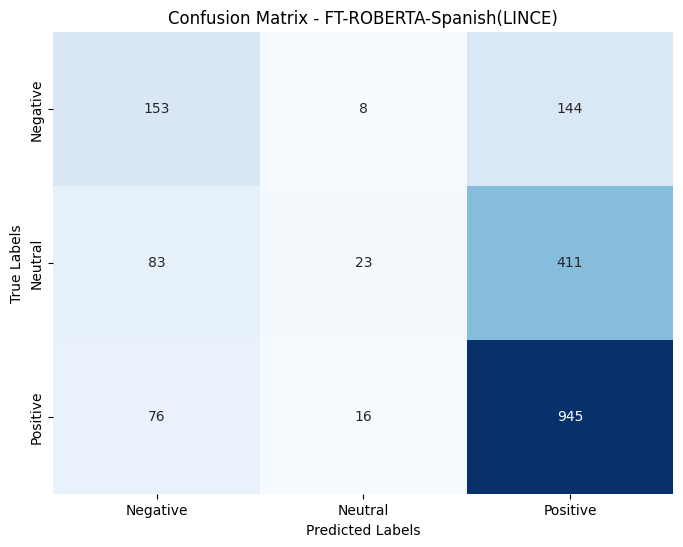

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, preds)
print(conf_matrix)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - FT-ROBERTA-Spanish(LINCE)")
plt.show()

In [ ]:
from google.colab import files
import shutil

# Path to the model directory in Google Colab
model_dir = "./fine_tuned_ROBERTA-LINCE"

# Create a zip file of the model directory
shutil.make_archive("fine_tuned_ROBERTA-LINCE", "zip", model_dir)

'/content/fine_tuned_ROBERTA-LINCE.zip'